# Transfer learning using Fast AI library

## Motivation

I am currently doing a fast.ai Live MOOC called "Practical Deep learning for Coders" which will be publically available in January 2019 on [fast.ai](http://www.fast.ai/) website. The following code is based on lesson 1 from that course. I will be using [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163?gi=b61aa5bd7f45). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models. I am writing this blog as a part of experimenting the course example on a dataset which is different in structure and complexity and to show how easy it is to use fastai library.

In the below example you will see how ridiculously easy is to do transfer learning and achieve world-class results on [PlantVintage Dataset](https://plantvillage.psu.edu/). PlantVintage data have images of plant leaves which consist of 38 disease classes which are commonly found on crops  and one background class from Stanford's open dataset of background images - [DAGS](http://dags.stanford.edu/projects/scenedataset.html). I downloaded data from links given on [this Github Repo](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases). I am particularly interested in this example because at the time I am writing this blog I work for an organization which helps farmers grow their business by providing products and tech solutions for better farm management. Let's get started~

### Boilerplate command

It's a standard practice to start jupyter notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

### Importing Fast AI library

Let's import fastai library and define our batch_size parameter to 64. Usually, image databases are huge, so we need to feed these images into a GPU using batches, batch size 64 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai import *
from fastai.vision import *
bs =64

### Looking at the data

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like. Our data is already split in train and validation folder, and inside each subdirectory, our folder name represents the class name of all the images present within that subfolder. Fortunately, the fastai library has a handy function made exactly for this, [ImageDataBunch.from_folder](https://docs.fast.ai/vision.data#ImageDataBunch.from_folder) gets the label names from the folder name automatically. fastai library have an [awesome documentation](https://docs.fast.ai/) to navigate through their library functions with live examples on how to use them. Once the data is loaded, we can also normalize the data by using .normalize to ImageNet parameters.

In [8]:
## Declaring path of dataset
path_img = Path('/home/jupyter/fastai_v3_experimentation/data/PlantVillage/')

## Loading data and Normalizing data based on Image net parameters
ds_tfms = get_transforms()
data = (ImageItemList.from_folder(path_img)
        .split_by_folder(train='train', valid='val')
        .label_from_folder()
        .transform(tfms=ds_tfms, size=224)
        .databunch(bs=bs)).normalize(imagenet_stats)

To look at a random sample of images, we can use .show_batch() function ImageDataBunch class. As we can see below we have some cases of diseases leaf on different crops plus some background noise images from DAGS dataset which will act as noise.

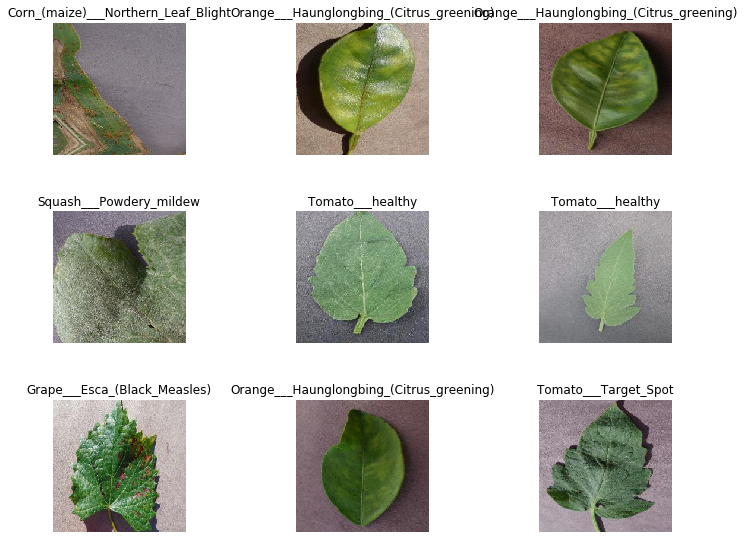

In [16]:
data.show_batch(rows=3, figsize=(10,8))

Let's print all the data classes present in the database. In total, we have images in 39 classes as mentioned above in the motivation section.

In [17]:
print(data.classes)
len(data.classes),data.c

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

(39, 39)

## Transfer learning using a pretrained model : ResNet 50

Now we will start training our model. We will use a convolutional neural network backbone [ResNet 50](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) and a fully connected head with a single hidden layer as a classifier. You can also read the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf) if you want to understand all the architecture detail. To create the transfer learing model we will need to use function create_cnn from Learner class and feed a pretrained model from models class.

In [22]:
## To create a ResNET 50 with pretrained weights
learn = create_cnn(data, models.resnet50, metrics=error_rate)

The ResNet50 model created by create_cnn function have initial layers frozen and we are just going to learn weights of the last fully connected layers.

In [23]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate
1,0.205355,0.113073,0.037623
2,0.114714,0.046579,0.015085
3,0.066878,0.028864,0.008815
4,0.043423,0.022405,0.007270
5,0.027287,0.018803,0.005634


As we can see above by just running five epochs with the default setting our accuracy for this fine-grained classification task is around ~99.64% on the validation dataset. Let's save the model as we are going to fine tune it later. If you want to know how good this result is, it already beats the shallow learning(only training last layer) benchmark of 96.53% from this [Github Page](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases).

In [24]:
learn.save('plant_vintage_stage1')

FastAI library also provides functions to explore results faster and find if our model is learning what it is supposed to learn.
We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not using ClassificationInterpretation class.

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

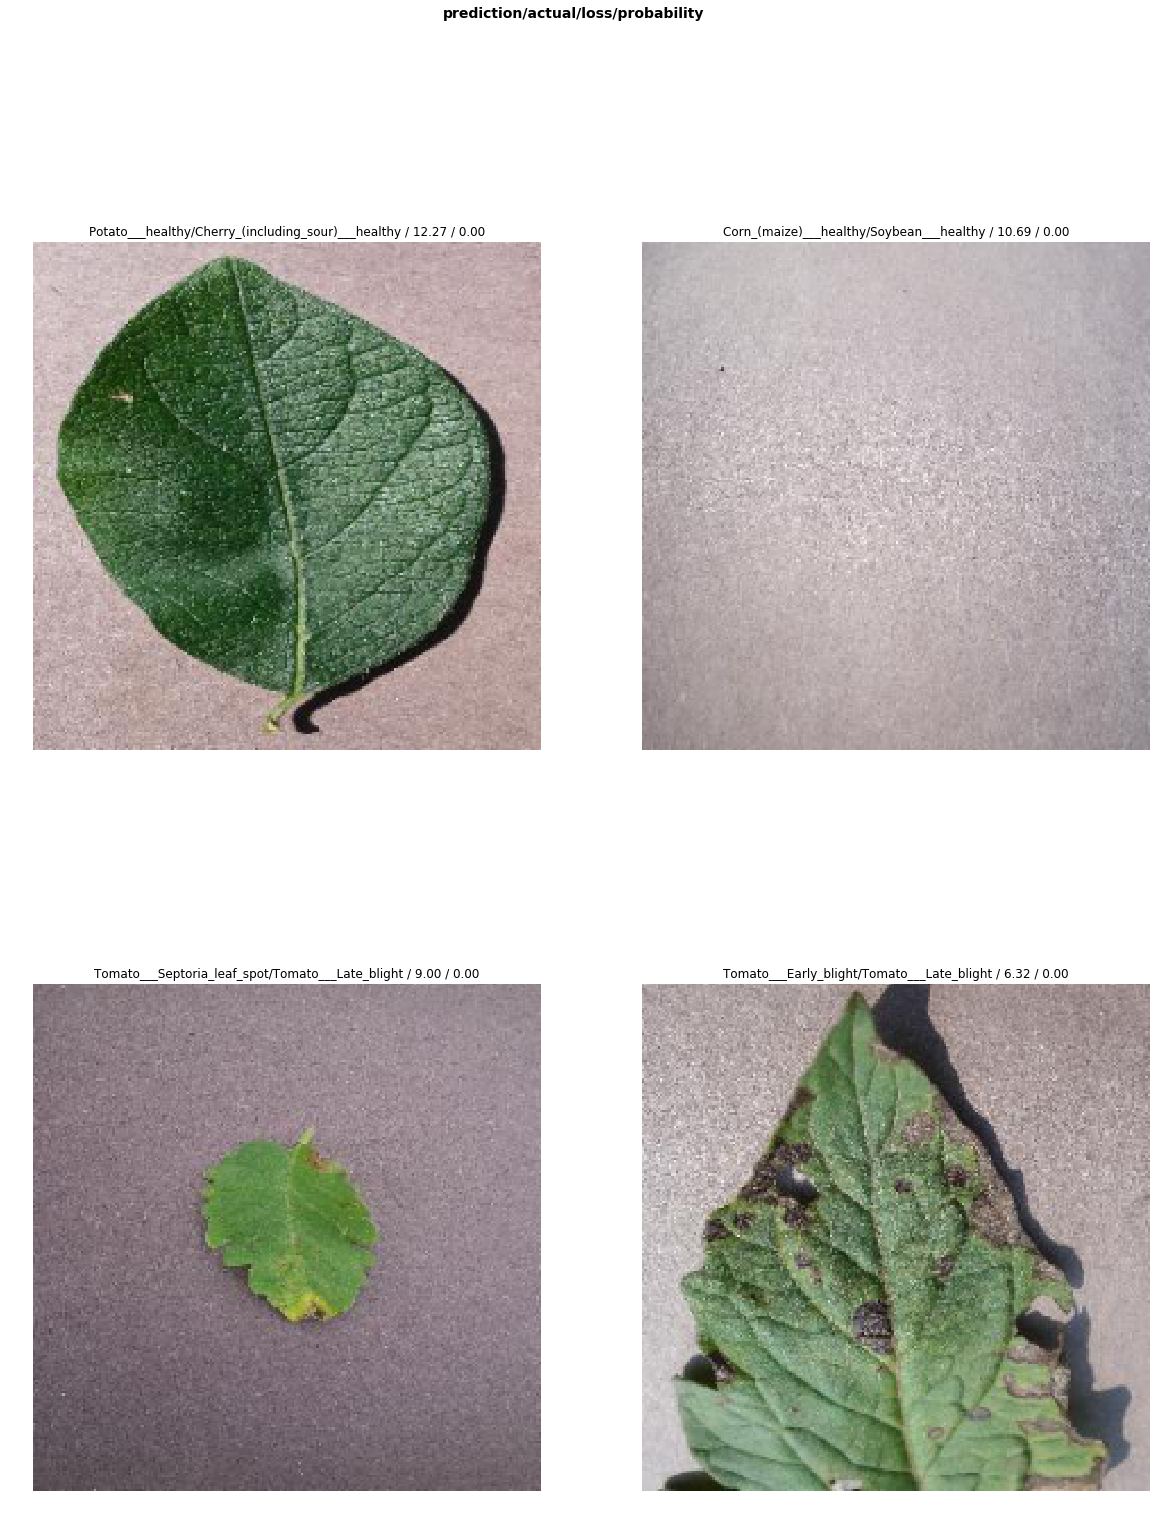

In [26]:
interp.plot_top_losses(4, figsize=(20,25))

In this case, the model is getting confused in detecting Northern Leaf blight from Gray leaf spots on Corn plant and early/late blight in tomato leaves which visually looks pretty similar. This is an indicator that our classifier is working correctly.
Furthermore, when we plot the confusion matrix, we can see that most of the things are classified correctly, and it's almost a near perfect model.

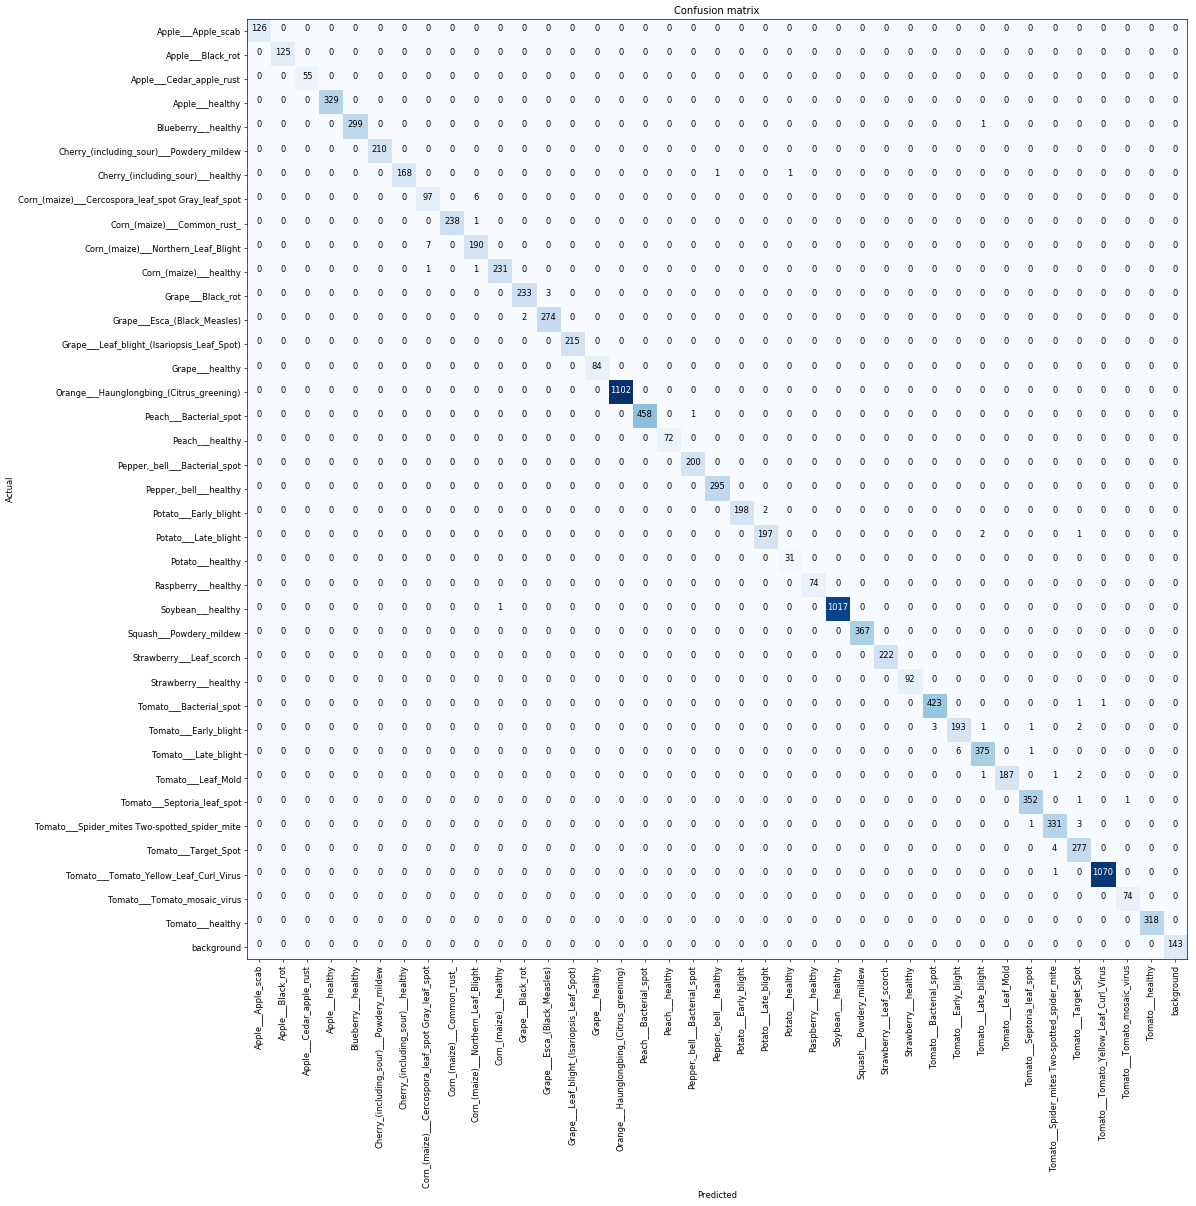

In [27]:
interp.plot_confusion_matrix(figsize=(20,20), dpi=60)

So until now we have only been training the last classification layers, but what if we want to optimize earlier layers too. In transfer learning playing with earlier layers should be done with caution and the learning rate should be kept pretty low. FastAI library provides a function to see what will be the ideal learning rate to train upon, so let's plot it. The lr_find function runs the model for a subset of data at multiple learning rate to determine which learning rate would be best.

In [31]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


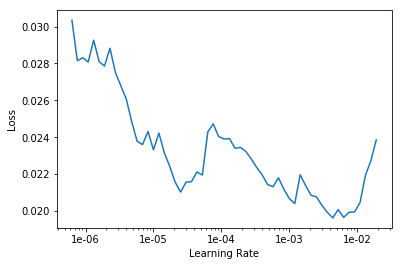

In [32]:
learn.recorder.plot()

It looks like we should keep our learning rate lower than 10e-4. We can use slice function to logarithmically distribute learning rate between 10e-6 to 10e-4 for different layers in the network. Keeping the lowest learning rate for the initial layers and increasing it for later layers. Let's unfreeze all the layers so that we can train the entire model using unfreeze() function.

In [33]:
learn.load('plant_vintage_stage1')

Learner(data=ImageDataBunch;

Train: LabelList
y: CategoryList (44016 items)
[Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus]...
Path: /home/jupyter/fastai_v3_experimentation/data/PlantVillage
x: ImageItemList (44016 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/fastai_v3_experimentation/data/PlantVillage;

Valid: LabelList
y: CategoryList (11004 items)
[Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus, Category Tomato___Tomato_mosaic_virus]...
Path: /home/jupyter/fastai_v3_experimentation/data/PlantVillage
x: ImageItemList (11004 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path

In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.022825,0.018372,0.005362
2,0.023123,0.017739,0.005089


In [35]:
learn.save('plant_vintage_stage2')

As we can see by training all the layers, we improved our accuracy to 99.7% which is comparable to 99.76% on the [Github benchmark](https://github.com/MarkoArsenovic/DeepLearning_PlantDiseases) using Inception-v3 model.

## Conclusion

Fast.ai is an excellent initiative by Jeremy Howard and his team, and I believe fastai library can genuinely achieve the motive of democratizing deep learning to everyone by making building deep learning models super simple.